##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 基于注意力的神经机器翻译

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.google.cn/tutorials/text/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    在 TensorFlow.org 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/zh-cn/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    在 Google Colab 运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/zh-cn/tutorials/text/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/zh-cn/tutorials/text/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />下载此 notebook</a>
  </td>
</table>

Note: 我们的 TensorFlow 社区翻译了这些文档。因为社区翻译是尽力而为， 所以无法保证它们是最准确的，并且反映了最新的
[官方英文文档](https://www.tensorflow.org/?hl=en)。如果您有改进此翻译的建议， 请提交 pull request 到
[tensorflow/docs](https://github.com/tensorflow/docs) GitHub 仓库。要志愿地撰写或者审核译文，请加入
[docs-zh-cn@tensorflow.org Google Group](https://groups.google.com/a/tensorflow.org/forum/#!forum/docs-zh-cn)。

此笔记本训练一个将西班牙语翻译为英语的序列到序列（sequence to sequence，简写为 seq2seq）模型。此例子难度较高，需要对序列到序列模型的知识有一定了解。

训练完此笔记本中的模型后，你将能够输入一个西班牙语句子，例如 *"¿todavia estan en casa?"*，并返回其英语翻译 *"are you still at home?"*

对于一个简单的例子来说，翻译质量令人满意。但是更有趣的可能是生成的注意力图：它显示在翻译过程中，输入句子的哪些部分受到了模型的注意。

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

请注意：运行这个例子用一个 P100 GPU 需要花大约 10 分钟。

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    # %tensorflow_version 仅存在于 Colab
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## 下载和准备数据集

我们将使用 http://www.manythings.org/anki/ 提供的一个语言数据集。这个数据集包含如下格式的语言翻译对：

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

这个数据集中有很多种语言可供选择。我们将使用英语 - 西班牙语数据集。为方便使用，我们在谷歌云上提供了此数据集的一份副本。但是你也可以自己下载副本。下载完数据集后，我们将采取下列步骤准备数据：

1. 给每个句子添加一个 *开始* 和一个 *结束* 标记（token）。
2. 删除特殊字符以清理句子。
3. 创建一个单词索引和一个反向单词索引（即一个从单词映射至 id 的词典和一个从 id 映射至单词的词典）。
4. 将每个句子填充（pad）到最大长度。

In [3]:
# 下载文件
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2646016/2638744 [==============================] - 3s 1us/step


In [4]:
# 将 unicode 文件转换为 ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # 例如： "he is a boy." => "he is a boy ."
    # 参考：https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # 给句子加上开始和结束标记
    # 以便模型知道何时开始和结束预测
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
# 1. 去除重音符号
# 2. 清理句子
# 3. 返回这样格式的单词对：[ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

    return zip(*word_pairs)

In [7]:
en, sp = create_dataset(path_to_file, None)
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def max_length(tensor):
    return max(len(t) for t in tensor)

In [9]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, lang_tokenizer

In [10]:
def load_dataset(path, num_examples=None):
    # 创建清理过的输入输出对
    targ_lang, inp_lang = create_dataset(path, num_examples)

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### 限制数据集的大小以加快实验速度（可选）

在超过 10 万个句子的完整数据集上训练需要很长时间。为了更快地训练，我们可以将数据集的大小限制为 3 万个句子（当然，翻译质量也会随着数据的减少而降低）：

In [11]:
# 尝试实验不同大小的数据集
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# 计算目标张量的最大长度 （max_length）
max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)

In [12]:
# 采用 80 - 20 的比例切分训练集和验证集
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 显示长度
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [13]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
12 ----> me
3428 ----> mude
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
602 ----> moved
3 ----> .
2 ----> <end>


### 创建一个 tf.data 数据集

In [15]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 16]), TensorShape([64, 11]))

## 编写编码器 （encoder） 和解码器 （decoder） 模型

实现一个基于注意力的编码器 - 解码器模型。关于这种模型，你可以阅读 TensorFlow 的 [神经机器翻译 (序列到序列) 教程](https://github.com/tensorflow/nmt)。本示例采用一组更新的 API。此笔记本实现了上述序列到序列教程中的 [注意力方程式](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)。下图显示了注意力机制为每个输入单词分配一个权重，然后解码器将这个权重用于预测句子中的下一个单词。下图和公式是 [Luong 的论文](https://arxiv.org/abs/1508.04025v5)中注意力机制的一个例子。

<img src="./img/attention_mechanism.jpg" width="500" alt="attention mechanism">

输入经过编码器模型，编码器模型为我们提供形状为 *(批大小，最大长度，隐藏层大小)* 的编码器输出和形状为 *(批大小，隐藏层大小)* 的编码器隐藏层状态。

下面是所实现的方程式：

<img src="./img/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="./img/attention_equation_1.jpg" alt="attention equation 1" width="800">

本教程的编码器采用 [Bahdanau 注意力](https://arxiv.org/pdf/1409.0473.pdf)。在用简化形式编写之前，让我们先决定符号：

* FC = 完全连接（密集）层
* EO = 编码器输出
* H = 隐藏层状态
* X = 解码器输入

以及伪代码：

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`。 Softmax 默认被应用于最后一个轴，但是这里我们想将它应用于 *第一个轴*, 因为分数 （score） 的形状是 *(批大小，最大长度，隐藏层大小)*。最大长度 （`max_length`） 是我们的输入的长度。因为我们想为每个输入分配一个权重，所以 softmax 应该用在这个轴上。
* `context vector = sum(attention weights * EO, axis = 1)`。选择第一个轴的原因同上。
* `embedding output` = 解码器输入 X 通过一个嵌入层。
* `merged vector = concat(embedding output, context vector)`
* 此合并后的向量随后被传送到 GRU

每个步骤中所有向量的形状已在代码的注释中阐明：

In [17]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# 样本输入
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [19]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # 隐藏层的形状 == （批大小，隐藏层大小）
        # hidden_with_time_axis 的形状 == （批大小，1，隐藏层大小）
        # 这样做是为了执行加法以计算分数
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # 分数的形状 == （批大小，最大长度，1）
        # 我们在最后一个轴上得到 1， 因为我们把分数应用于 self.V
        # 在应用 self.V 之前，张量的形状是（批大小，最大长度，单位）
        score = self.V(
            tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # 注意力权重 （attention_weights） 的形状 == （批大小，最大长度，1）
        attention_weights = tf.nn.softmax(score, axis=1)

        # 上下文向量 （context_vector） 求和之后的形状 == （批大小，隐藏层大小）
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [20]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


In [21]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(vocab_size)

        # 用于注意力
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # 编码器输出 （enc_output） 的形状 == （批大小，最大长度，隐藏层大小）
        context_vector, attention_weights = self.attention(hidden, enc_output)

        # x 在通过嵌入层后的形状 == （批大小，1，嵌入维度）
        x = self.embedding(x)

        # x 在拼接 （concatenation） 后的形状 == （批大小，1，嵌入维度 + 隐藏层大小）
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # 将合并后的向量传送到 GRU
        output, state = self.gru(x)

        # 输出的形状 == （批大小 * 1，隐藏层大小）
        output = tf.reshape(output, (-1, output.shape[2]))

        # 输出的形状 == （批大小，vocab）
        x = self.fc(output)

        return x, state, attention_weights

In [22]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 定义优化器和损失函数

In [23]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

## 检查点（基于对象保存）

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 训练

1. 将 *输入* 传送至 *编码器*，编码器返回 *编码器输出* 和 *编码器隐藏层状态*。
2. 将编码器输出、编码器隐藏层状态和解码器输入（即 *开始标记*）传送至解码器。
3. 解码器返回 *预测* 和 *解码器隐藏层状态*。
4. 解码器隐藏层状态被传送回模型，预测被用于计算损失。
5. 使用 *教师强制 （teacher forcing）* 决定解码器的下一个输入。
6. *教师强制* 是将 *目标词* 作为 *下一个输入* 传送至解码器的技术。
7. 最后一步是计算梯度，并将其应用于优化器和反向传播。

In [25]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] *
                                   BATCH_SIZE, 1)

        # 教师强制 - 将目标词作为下一个输入
        for t in range(1, targ.shape[1]):
            # 将编码器输出 （enc_output） 传送至解码器
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                                 enc_output)

            loss += loss_function(targ[:, t], predictions)

            # 使用教师强制
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [26]:
EPOCHS = 5

for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
                epoch + 1, batch, batch_loss.numpy()))
    # 每 2 个周期（epoch），保存（检查点）一次模型
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6023
Epoch 1 Batch 100 Loss 2.1158
Epoch 1 Batch 200 Loss 1.8639
Epoch 1 Batch 300 Loss 1.7150
Epoch 1 Loss 2.0167
Time taken for 1 epoch 943.3117020130157 sec

Epoch 2 Batch 0 Loss 1.4880
Epoch 2 Batch 100 Loss 1.4871
Epoch 2 Batch 200 Loss 1.2971
Epoch 2 Batch 300 Loss 1.1837
Epoch 2 Loss 1.3627
Time taken for 1 epoch 958.1314051151276 sec

Epoch 3 Batch 0 Loss 1.0060
Epoch 3 Batch 100 Loss 1.0004
Epoch 3 Batch 200 Loss 0.8758
Epoch 3 Batch 300 Loss 0.8301
Epoch 3 Loss 0.9356
Time taken for 1 epoch 1042.2323021888733 sec

Epoch 4 Batch 0 Loss 0.6176
Epoch 4 Batch 100 Loss 0.6259
Epoch 4 Batch 200 Loss 0.5790
Epoch 4 Batch 300 Loss 0.5839
Epoch 4 Loss 0.6183
Time taken for 1 epoch 1280.2978203296661 sec

Epoch 5 Batch 0 Loss 0.3799
Epoch 5 Batch 100 Loss 0.4281
Epoch 5 Batch 200 Loss 0.4249
Epoch 5 Batch 300 Loss 0.4342
Epoch 5 Loss 0.4130
Time taken for 1 epoch 1320.4021170139313 sec



## 翻译

* 评估函数类似于训练循环，不同之处在于在这里我们不使用 *教师强制*。每个时间步的解码器输入是其先前的预测、隐藏层状态和编码器输出。
* 当模型预测 *结束标记* 时停止预测。
* 存储 *每个时间步的注意力权重*。

请注意：对于一个输入，编码器输出仅计算一次。

In [27]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # 存储注意力权重以便后面制图
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.index_word[predicted_id] + ' '

        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # 预测的 ID 被输送回模型
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [28]:
# 注意力权重制图函数
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [29]:
def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 恢复最新的检查点并验证

In [30]:
# 恢复检查点目录 （checkpoint_dir） 中最新的检查点
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold ! <end> 


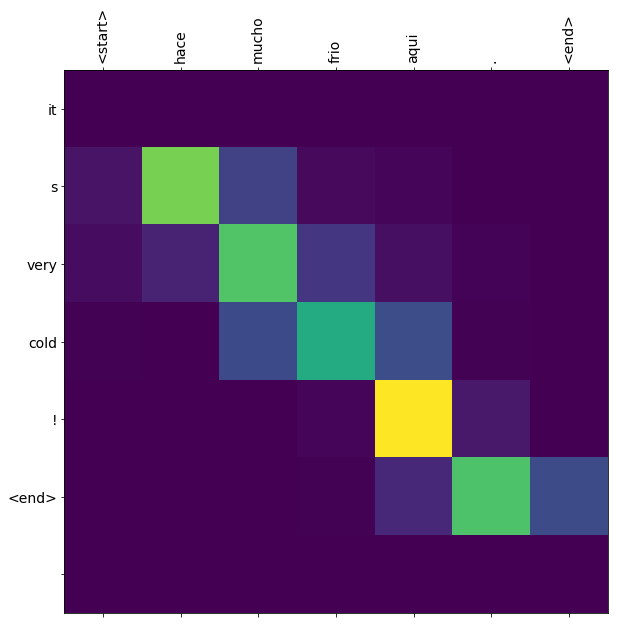

In [31]:
translate(u'hace mucho frio aqui.')

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


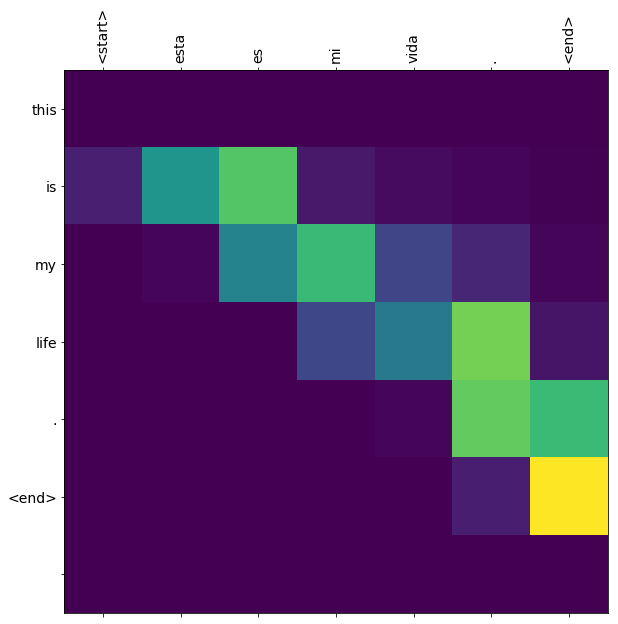

In [32]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are still still home ? <end> 


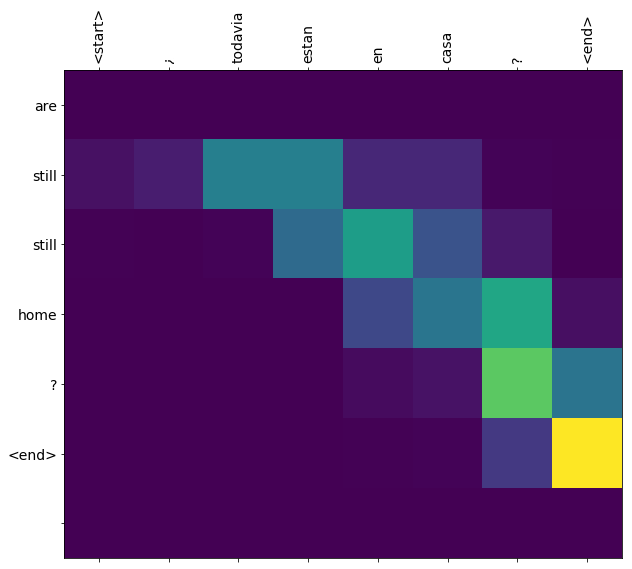

In [33]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to be to sing . <end> 


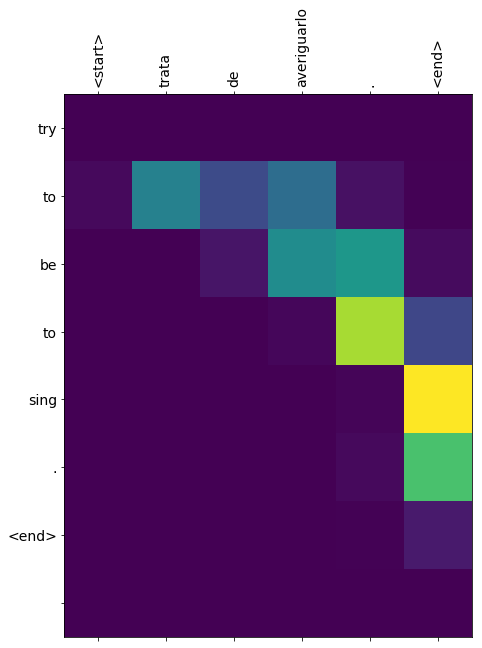

In [34]:
# 错误的翻译
translate(u'trata de averiguarlo.')

## 下一步

* [下载一个不同的数据集](http://www.manythings.org/anki/)实验翻译，例如英语到德语或者英语到法语。
* 实验在更大的数据集上训练，或者增加训练周期。